In [1]:
import timesfm

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.


d:\Anaconda\envs\Tsm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
import ast

from datetime import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [31]:
print("Loading data file now, this could take a while depending on file size")
start = time.time()
df = pd.read_csv('co2_data.csv')
end = time.time()
print("Loading took " + str(round(end - start, 2)) + " seconds")

Loading data file now, this could take a while depending on file size
Loading took 0.0 seconds


In [10]:
timesfm_backend = "gpu"  

model = timesfm.TimesFm(  
    hparams=timesfm.TimesFmHparams( 
        backend=timesfm_backend,  # ระบุ backend ที่ใช้ เช่น GPU (ค่าถูกกำหนดจากตัวแปร timesfm_backend)
        per_core_batch_size=32,  # ขนาดของ batch ต่อ core ที่ใช้ใน data parallelism (กระบวนการประมวลผลขนาน)
        horizon_len=16,  # ความยาวของช่วงเวลาที่โมเดลจะทำนายล่วงหน้า (forecast horizon)
        num_layers=50,  # จำนวนชั้น (layers) ของ Transformer ในโมเดล
        use_positional_embedding=False,  # ระบุว่าจะใช้ positional embedding หรือไม่ (False แปลว่าไม่ใช้)
        context_len=32*5,  # ความยาวของบริบท (context length) ที่โมเดลสามารถรับข้อมูลในแต่ละครั้ง
    ),
    checkpoint=timesfm.TimesFmCheckpoint(  # กำหนด checkpoint สำหรับโหลดน้ำหนักที่ผ่านการฝึกฝนแล้ว
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"  # ไฟล์น้ำหนักโมเดลจาก repository Hugging Face
    ),
)


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 3002.37it/s]


In [ ]:
df['ds'] = pd.date_range(start=pd.to_datetime(df['Year'], format='%Y').min(), periods=len(df), freq='W')
df.drop(columns=['Year','Year&Month'], inplace=True)
df.head()

,CO2,ds
0,333.13,1974-01-01
1,332.09,1974-01-02
2,331.10,1974-01-03
3,329.14,1974-01-04
4,327.36,1974-01-05


In [33]:
df['unique_id'] = range(1, len(df) + 1)
df.head()

,CO2,ds,unique_id
0,333.13,1974-01-01,1
1,332.09,1974-01-02,2
2,331.10,1974-01-03,3
3,329.14,1974-01-04,4
4,327.36,1974-01-05,5


In [34]:
df.rename(columns={'CO2':'y'}, inplace=True)

In [35]:
df

,y,ds,unique_id
0,333.13,1974-01-01,1
1,332.09,1974-01-02,2
2,331.10,1974-01-03,3
3,329.14,1974-01-04,4
4,327.36,1974-01-05,5
...,...,...,...
156,351.71,1974-06-06,157
157,350.94,1974-06-07,158
158,349.10,1974-06-08,159
159,346.77,1974-06-09,160


In [36]:
forecast_df = model.forecast_on_df(
    inputs=df,
    freq="D",
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [38]:
def plot_levels_overtime(df=df, x_column=None, y_column=None):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_column], df[y_column], marker='o', markersize=5, markerfacecolor='red', color='blue', label=y_column)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f"{y_column} Levels Over Time")
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [40]:
forecast_df['ds'] = pd.date_range(start=pd.to_datetime(df['ds'].min(), format='%Y-%m-%d'), periods=len(forecast_df), freq='D')

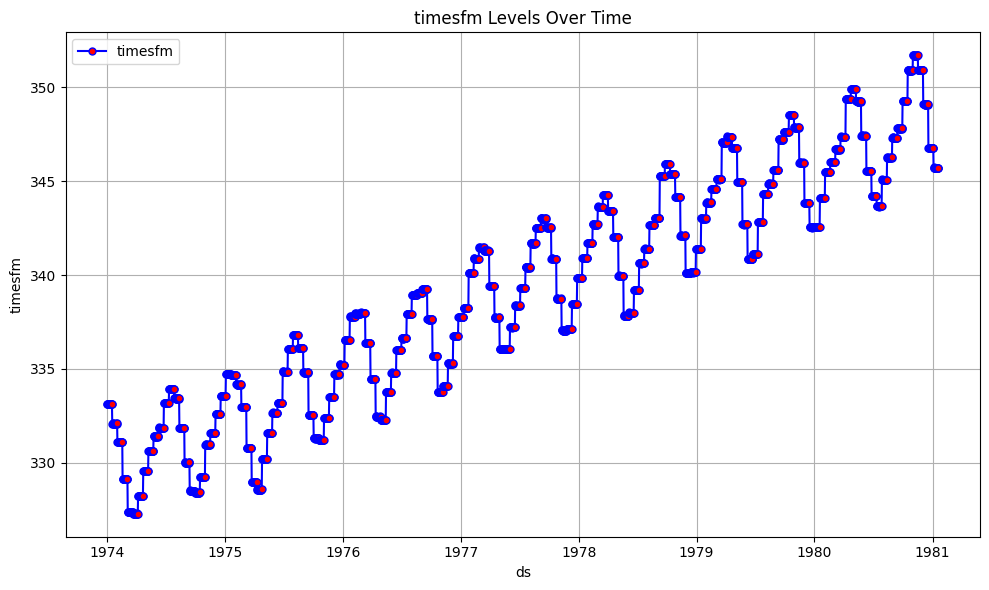

In [41]:
plot_levels_overtime(df=forecast_df, x_column='ds', y_column='timesfm')

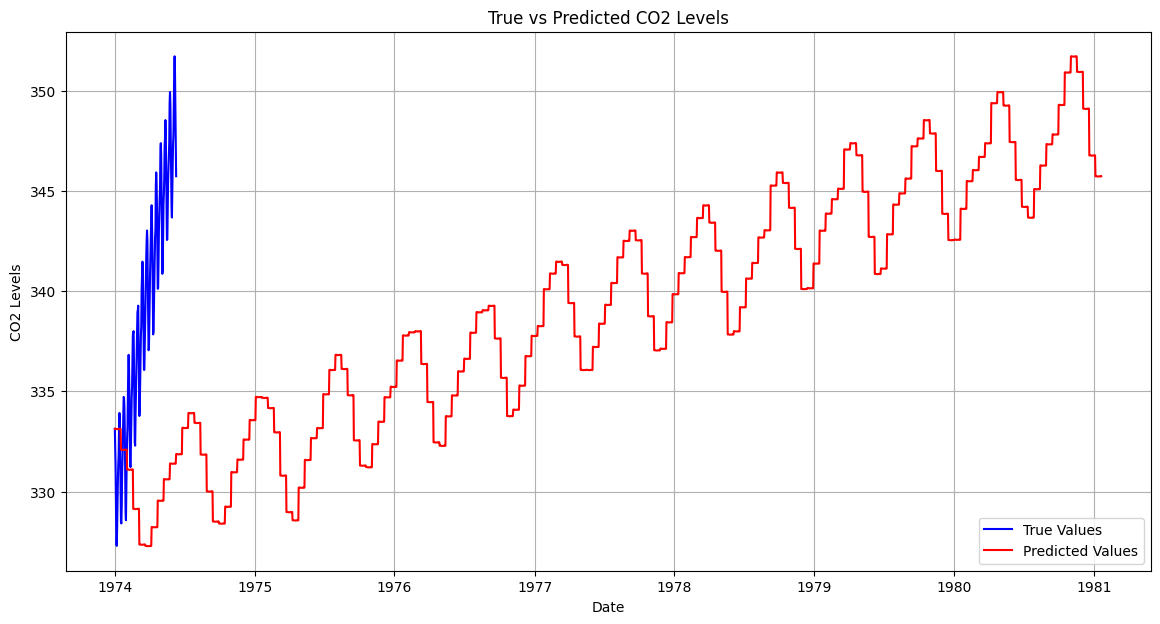

In [42]:
plt.figure(figsize=(14, 7))
plt.plot(df['ds'], df['y'], label='True Values', color='blue')
plt.plot(forecast_df['ds'], forecast_df['timesfm'], label='Predicted Values', color='red')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.title('True vs Predicted CO2 Levels')
plt.legend()
plt.grid(True)
plt.show()